<a href="https://colab.research.google.com/github/vinay-zzz/Mini-Project/blob/main/bitcoin_price_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [ ]:
# Import Bitcoin historical data using an API key and store it as a CSV file
api_key = 'e762b0c725164074a6fe1b591bdc7d42'
url = f'https://api.twelvedata.com/time_series?symbol=BTC/USD&interval=1day&outputsize=500&apikey={api_key}'
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data['values'])
df.to_csv('bitcoin_price.csv', index=False)

In [ ]:
# Clean the stored data and perform standardization
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df = df.astype(float)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [ ]:
# Split the data into training and testing sets
X = scaled_data[:-1]
y = scaled_data[1:, 3]  # Close price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Reshape input for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [ ]:
# Train LSTM and XGBoost models to predict the data
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)

# XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
# Predict the future Bitcoin price based on the last 3 months of live data
url_live = f'https://api.twelvedata.com/time_series?symbol=BTC/USD&interval=1day&outputsize=90&apikey={api_key}'
response_live = requests.get(url_live)
data_live = response_live.json()
df_live = pd.DataFrame(data_live['values'])
df_live['datetime'] = pd.to_datetime(df_live['datetime'])
df_live.set_index('datetime', inplace=True)
df_live = df_live.astype(float)
scaled_data_live = scaler.transform(df_live)
last_3_months = scaled_data_live.reshape(scaled_data_live.shape[0], 1, scaled_data_live.shape[1])
future_pred_lstm = lstm_model.predict(last_3_months)
future_pred_xgb = xgb_model.predict(scaled_data_live)

3/3 [==============================] - 0s 6ms/step


In [ ]:
# Inverse transform the predicted data to get the actual Bitcoin price
scaler_new = MinMaxScaler(feature_range=(0, 1))
scaler_new.min_, scaler_new.scale_ = scaler.min_[3:], scaler.scale_[3:]
future_pred_lstm_actual = scaler_new.inverse_transform(future_pred_lstm)
future_pred_xgb_actual = scaler_new.inverse_transform(future_pred_xgb.reshape(-1, 1)).flatten()

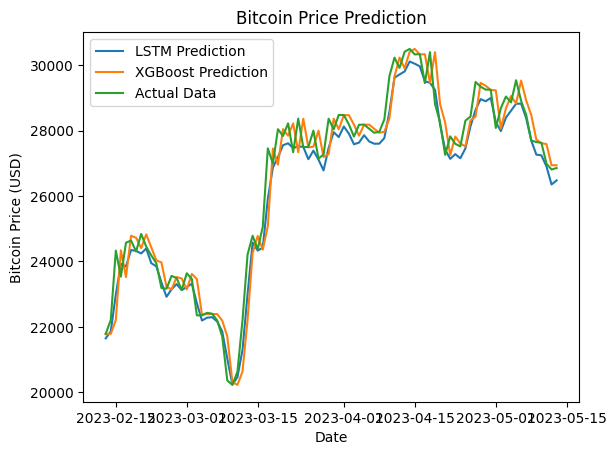

In [ ]:

# Display the graph of the predicted and actual data
plt.plot(df_live.index, future_pred_lstm_actual, label='LSTM Prediction')
plt.plot(df_live.index, future_pred_xgb_actual, label='XGBoost Prediction')
plt.plot(df_live.index, df_live['close'], label='Actual Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin Price Prediction')
plt.show()


In [ ]:
# Predict the Bitcoin price for the next 30 days using both models
last_30_days = scaled_data_live[-30:].reshape(30, 1, scaled_data_live.shape[1])
future_pred_lstm_30_days = lstm_model.predict(last_30_days)
future_pred_xgb_30_days = xgb_model.predict(scaled_data_live[-30:])
future_pred_lstm_30_days_actual = scaler_new.inverse_transform(future_pred_lstm_30_days)
future_pred_xgb_30_days_actual = scaler_new.inverse_transform(future_pred_xgb_30_days.reshape(-1, 1)).flatten()

1/1 [==============================] - 0s 22ms/step


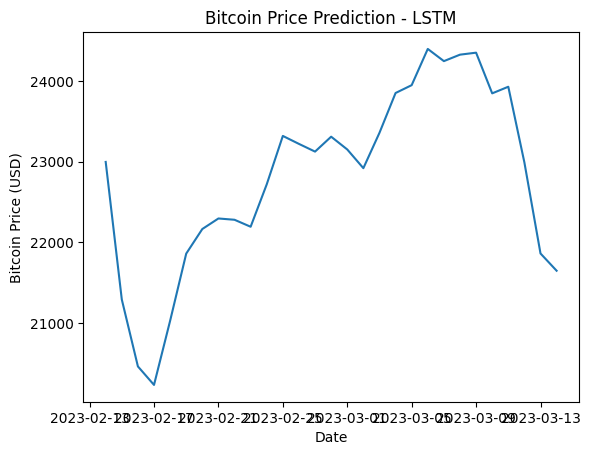

In [ ]:
# Generate the LSTM prediction graph for the next 30 days
future_dates = pd.date_range(start=df_live.index[-1], periods=30, freq='D')[1:]
future_pred_lstm_30_days_actual = future_pred_lstm_30_days_actual[1:]
plt.plot(future_dates, future_pred_lstm_30_days_actual, label='LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin Price Prediction - LSTM')
plt.show()

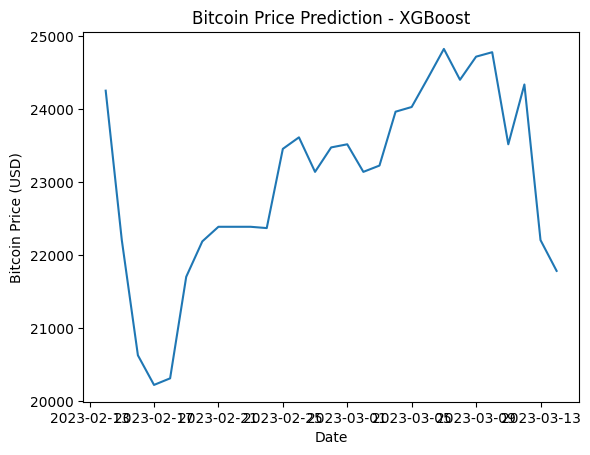

In [ ]:
# Generate the XGBoost prediction graph for the next 30 days
future_dates = pd.date_range(start=df_live.index[-1], periods=30, freq='D')[1:]
future_pred_xgb_30_days_actual = future_pred_xgb_30_days_actual[:-1]
plt.plot(future_dates, future_pred_xgb_30_days_actual, label='XGBoost Prediction')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin Price Prediction - XGBoost')
plt.show()

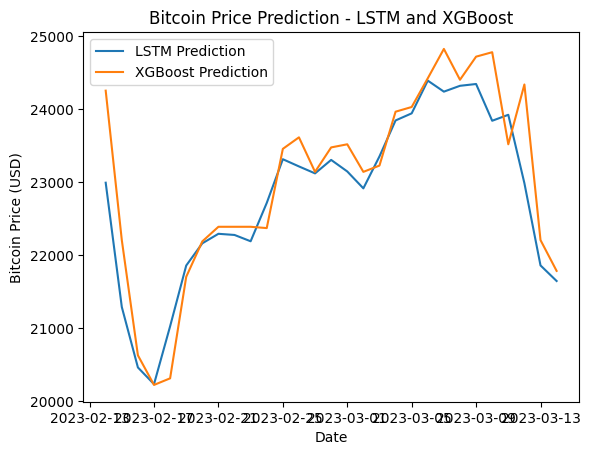

In [ ]:
# Generate the combined prediction graph for the next 30 days
plt.plot(future_dates, future_pred_lstm_30_days_actual, label='LSTM Prediction')
plt.plot(future_dates, future_pred_xgb_30_days_actual, label='XGBoost Prediction')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin Price Prediction - LSTM and XGBoost')
plt.legend()
plt.show()